In [78]:
import os
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score
from sklearn.calibration import calibration_curve
import joblib

from imblearn.over_sampling import RandomOverSampler

# 0. Read dataset

In [40]:
# path_csv = r"Dataset/tidyData_fe3.csv"
path_train_csv = r"Dataset/train.csv"

In [41]:
df_train = pd.read_csv(path_train_csv)
df_train.dropna(inplace=True)
df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
print(f"Shape of df_train: {df_train.shape}")

Shape of df_train: (295862, 23)


In [42]:
df_train, df_val = train_test_split(df_train, test_size=0.2)

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")

df_train.sample(5)

Shape of df_train: (236689, 23)
Shape of df_val: (59173, 23)


,periodTime,period,x-coordinate,y-coordinate,attackingSide,shot_distance,angle,isEmptyNet,shotType,last_event_type,coor_x_last_event,coor_y_last_event,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose,isgoal,period_second,game_second
208941,06:29,3,-62.0,-5.0,left,27.459060,-0.183111,0,Wrist Shot,Missed Shot,64.0,-5.0,14.0,126.000000,True,-1.104912,9.000000,0,5,5,1,389,3989
226981,14:07,1,79.0,3.0,right,10.440307,0.291457,0,Wrist Shot,Faceoff,0.0,0.0,18.0,79.056942,False,0.000000,4.392052,11,4,3,0,847,2047
45997,17:06,2,-50.0,-1.0,left,39.012818,-0.025635,0,Snap Shot,Giveaway,-96.0,7.0,4.0,46.690470,False,0.000000,11.672618,0,5,5,0,1026,3426
14458,08:58,3,81.0,-2.0,right,8.246211,-0.244979,0,Wrist Shot,Giveaway,-19.0,-1.0,4.0,100.005000,False,0.000000,25.001250,0,5,5,0,538,4138
193325,02:53,2,-73.0,18.0,left,24.083189,0.844154,0,Snap Shot,Takeaway,52.0,18.0,5.0,125.000000,False,0.000000,25.000000,0,5,5,0,173,2573


# 1. Add more feature

- In this section, we will add the new feature called `attacking_zone_shot`. This feature indicates whether the shot occurred in the attacking zone.
- We choose to analyze this feature based on the observation that the shot in the attacking zone has high chance to become a goal.
- **After analyzing**, we realize that 94.5% shot happend inside attacking zone, and 5% shot happened outside attacking zone.

In [43]:
def Is_Shot_In_Attacking_Zone(x_coordinate_shot, attacking_side):

    if str(attacking_side).lower() == "left":
        x_coordinate_net = -89
        attacking_zone_range = -25
        return x_coordinate_net <= x_coordinate_shot <= attacking_zone_range
    elif str(attacking_side).lower() == "right":
        x_coordinate_net = 89
        attacking_zone_range = 25
        return  attacking_zone_range <= x_coordinate_shot <= x_coordinate_net
    else:
        return None

In [44]:
df_train['attacking_zone_shot'] = df_train.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)
df_val['attacking_zone_shot'] = df_val.apply(lambda x: Is_Shot_In_Attacking_Zone(x['x-coordinate'], x['attackingSide']), axis=1)

# 2. Feature selection

- In this section, I will use **correlation** and **mutual information** to perform the feature selection.

### a. Correlation

- In this section, we will check the correlation value between pairs of features. If the correlation between two features are larger than specific `threshold`, we will remove it.

In [45]:
df_train.head()

,periodTime,period,x-coordinate,y-coordinate,attackingSide,shot_distance,angle,isEmptyNet,shotType,last_event_type,coor_x_last_event,coor_y_last_event,time_last_event,distance_last_event,is_rebound,Change in shot angle,Speed,power_play_time,n_friend,n_oppose,isgoal,period_second,game_second,attacking_zone_shot
133468,04:03,2,22.0,-36.0,right,76.059187,-0.493051,0,Wrist Shot,Giveaway,99.0,2.0,86.0,85.866175,False,0.000000,0.998444,0,5,5,0,243,2643,False
275536,08:04,1,-51.0,-14.0,left,40.496913,-0.352990,0,Wrist Shot,Giveaway,-49.0,-6.0,2.0,8.246211,False,0.000000,4.123106,0,5,5,0,484,1684,True
169334,00:40,1,-43.0,-13.0,left,47.801674,-0.275426,0,Wrist Shot,Takeaway,31.0,18.0,22.0,80.230917,True,-0.835786,3.646860,0,5,5,0,40,1240,True
82911,06:14,1,54.0,2.0,right,35.057096,0.057081,0,Snap Shot,Hit,98.0,5.0,4.0,44.102154,True,-0.016858,11.025539,0,5,5,0,374,1574,True
217427,06:54,2,71.0,3.0,right,18.248288,0.165149,0,Wrist Shot,Hit,-35.0,35.0,20.0,110.724884,True,-0.036168,5.536244,0,5,5,0,414,2814,True


In [48]:
list_features = ['game_second', 'period', 'x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet', 'last_event_type',\
                'coor_x_last_event', 'coor_y_last_event', 'time_last_event', 'distance_last_event', 'is_rebound',\
                 'Change in shot angle', 'Speed', 'power_play_time', 'n_friend', 'n_oppose', 'attacking_zone_shot']

labels = 'isgoal'

In [50]:
X_train = df_train[list_features]
y_train = df_train[labels]

X_val = df_val[list_features]
y_val = df_val[labels]

In [51]:
def List_High_Corr_Features(df, threshold=0.9):

    # Find numerical features
    numerical_features = df.select_dtypes(include=['int', 'float']).columns
    df = df[numerical_features]

    corr_matrix = df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    drop_features = [column for column in upper.columns if any(upper[column] > threshold)]
    # X = X.drop(drop_features, axis=1)

    return drop_features

In [52]:
# Remove high correlation features
threshold = 0.9
drop_features = List_High_Corr_Features(X_train, threshold=threshold)
print(f"[INFO] Drop high correlation: {drop_features}")

X_train = X_train.drop(drop_features, axis=1)
X_val = X_val.drop(drop_features, axis=1)

[INFO] Drop high correlation: ['period']


### b. Mutual information

- On this section, we will use mutual information to identify the relationship between features and the target variable. 
- From practical visualization, we will choose features, whose mutual information scores are above 0.01.

In [53]:
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns
categorical_features = [i for i in list(X_train.columns) if i not in numerical_features]

X_train_numerical = X_train[numerical_features]
X_train_categorical = X_train[categorical_features]

X_val_numerical = X_val[numerical_features]
X_val_categorical = X_val[categorical_features]

In [54]:
mi_selector = SelectKBest(mutual_info_classif, k='all')
mi_selector.fit(X_train_numerical, y_train)

# Get feature scores
feature_scores = mi_selector.scores_

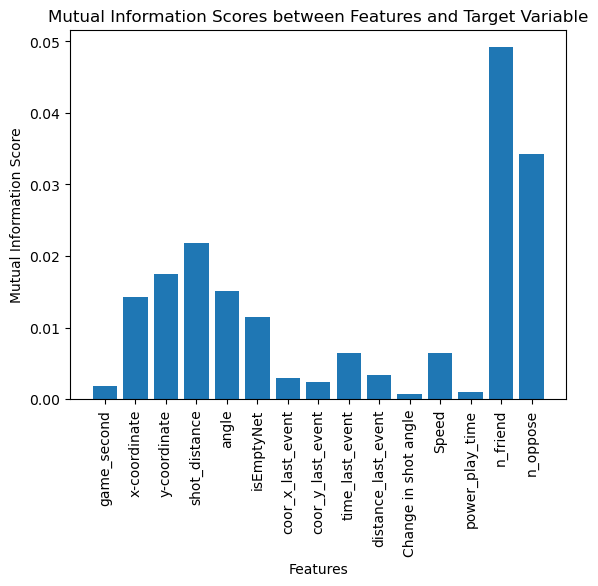

In [55]:
# Create a bar chart
plt.bar(X_train_numerical.columns, feature_scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores between Features and Target Variable')
plt.savefig(os.path.join('images', "best_shot_model", "mutual_information.jpg"))
plt.show()

- According to the experiment, we will set the threshold below **0.01**

In [56]:
threshold_mi = 0.01
selected_features = X_train_numerical.columns[mi_selector.scores_ > threshold_mi]
print(f"Selected features (mutual information): {selected_features}")

X_train_numerical = X_train_numerical[selected_features]
X_val_numerical = X_val_numerical[selected_features]

Selected features (mutual information): Index(['x-coordinate', 'y-coordinate', 'shot_distance', 'angle', 'isEmptyNet',
       'n_friend', 'n_oppose'],
      dtype='object')


### c. Convert categorical feature into one-hot vector

In [57]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train_categorical)

X_train_categorical = encoder.transform(X_train_categorical).toarray()
X_val_categorical = encoder.transform(X_val_categorical).toarray()

### d. Convert numerical features

In [58]:
scaler = StandardScaler()
scaler.fit(X_train_numerical)

X_train_numerical = scaler.transform(X_train_numerical)
X_val_numerical = scaler.transform(X_val_numerical)

In [59]:
X_train = np.concatenate([X_train_numerical, X_train_categorical], axis=1)
X_val = np.concatenate([X_val_numerical, X_val_categorical], axis=1)

print(f'Shape of X train: {X_train.shape}')
print(f'Shape of X val: {X_val.shape}')

Shape of X train: (236689, 26)
Shape of X val: (59173, 26)


### e. Balance dataset

In [60]:
over_sampler = RandomOverSampler(sampling_strategy=0.3) 

X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

In [61]:
print(Counter(y_train))
print(Counter(y_train_resampled))

Counter({0: 214632, 1: 22057})
Counter({0: 214632, 1: 64389})


# 3. Building machine learning model

### a. Decision Tree

In [62]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [5, 10],
}

dt_classifier = DecisionTreeClassifier()

grid_search = GridSearchCV(dt_classifier, param_grid_tree, cv=5, scoring='roc_auc')
# grid_search.fit(X_train, y_train)
grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
tree = grid_search.best_estimator_

print("Best Parameters:", best_params)
print(f"Best score: {grid_search.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 4}
Best score: 0.7562763834711991


In [63]:
y_val_pred = tree.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy validation set: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)    

Accuracy validation set: 0.91
Confusion Matrix:
[[53357   438]
 [ 4970   408]]


In [76]:
path_output_tree_model = os.path.join("models", "decision_tree.pkl")
joblib.dump(tree, path_output_tree_model)

['models/decision_tree.pkl']

### b. KNN

In [64]:
param_grid_knn = {
    'n_neighbors': [2, 3],
    'weights': ['uniform', 'distance']
}

knn_classifier = KNeighborsClassifier()

grid_search = GridSearchCV(knn_classifier, param_grid_knn, cv=5, scoring='roc_auc', n_jobs=2)
# grid_search.fit(X_train, y_train)
grid_search.fit(X_train_resampled, y_train_resampled)

knn_best = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print(f"Best score: {grid_search.best_score_}")

Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.8100806742527539


In [65]:
y_val_pred = knn_best.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

print(f"Accuracy validation set: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy validation set: 0.86
Confusion Matrix:
[[49983  3812]
 [ 4487   891]]


In [77]:
path_output_knn_model = os.path.join("models", "knn.pkl")
joblib.dump(knn_best, path_output_knn_model)

['models/knn.pkl']

# 5. Visualization

In [66]:
y_val_pred_proba_tree = tree.predict_proba(X_val)[:, 1]
y_val_pred_proba_knn = knn_best.predict_proba(X_val)[:, 1]

models = ['decision tree', 'knn']
probs = [y_val_pred_proba_tree, y_val_pred_proba_knn]

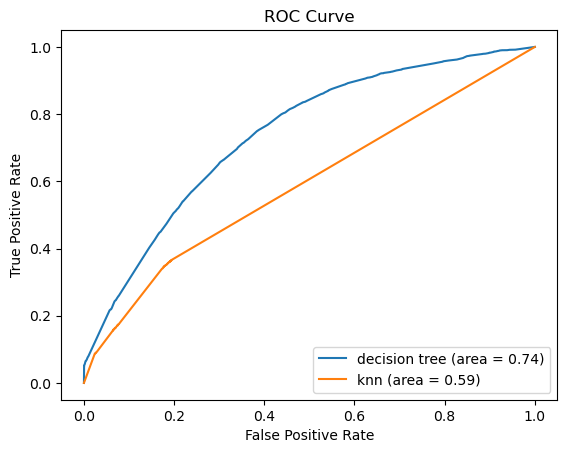

In [67]:
fig = plt.figure()

for i in range(len(models)):
    fpr, tpr, _ = roc_curve(y_val, probs[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{models[i]} (area = {round(roc_auc, 2)})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

path_output_image = os.path.join("images", "best_shot_model", "roc.jpg")
fig.savefig(path_output_image)
# experiment.log_figure(figure=fig)

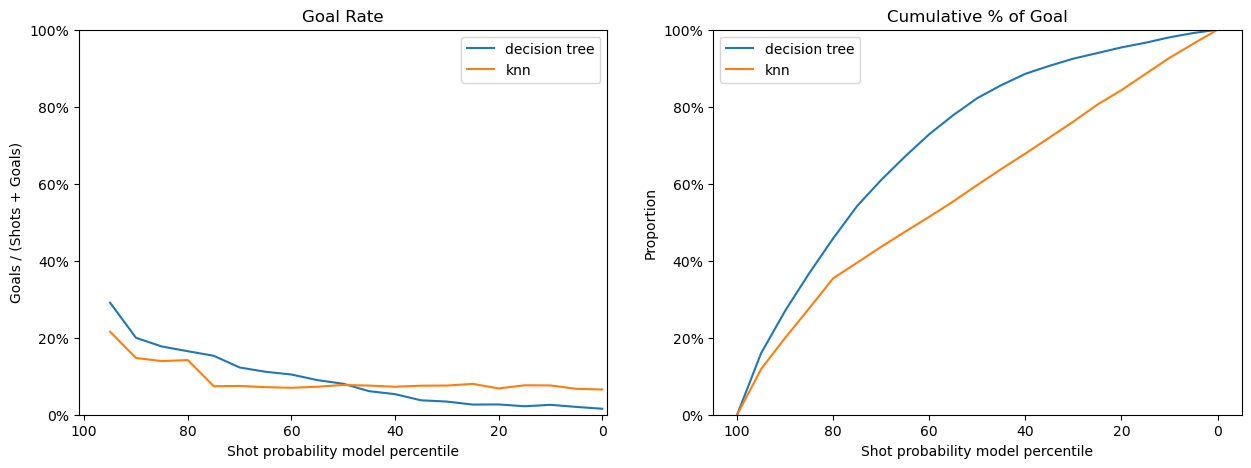

In [68]:
bins = np.linspace(0, 95, num=20).astype(int)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

list_plot_points = list()
for i in range(len(models)):
    perentiles = (np.argsort(np.argsort(probs[i])) + 1) * 100.0 / (len(probs[i]))
    perentile_bins = (np.digitize(perentiles, bins) - 1) * 5
    plot_points = pd.DataFrame(columns=["bin", "goal_rate", "goal_cum"])
    goal_cum = 0
    for j, bin in enumerate(np.flip(bins)):
        n_goal = np.sum(y_val[perentile_bins == bin])
        n_shot = np.sum(perentile_bins == bin)
        goal_rate = n_goal / n_shot
        goal_cum += n_goal / np.sum(y_val)
        plot_points.loc[j] = [bin, goal_rate, goal_cum]
    list_plot_points.append(plot_points)

    sns.lineplot(
        data=plot_points,
        x="bin",
        y="goal_rate",
        legend=False,
        label="%s" % (models[i]),
        ax=axs[0],
    )

    plot_points.loc[j + 1] = [100, 0, 0]
    sns.lineplot(
        data=plot_points,
        x="bin",
        y="goal_cum",
        legend=False,
        label="%s" % (models[i]),
        ax=axs[1],
    )


axs[0].set_title(f"Goal Rate")
axs[0].set_xlabel("Shot probability model percentile")
axs[0].set_ylabel("Goals / (Shots + Goals)")
axs[0].set_xlim(left=101, right=-1)
axs[0].set_ylim(bottom=0, top=1)
vals = axs[0].get_yticks()
axs[0].set_yticks(vals)
axs[0].set_yticklabels(["{:,.0%}".format(x) for x in vals])
axs[0].legend()

axs[1].set_title(f"Cumulative % of Goal")
axs[1].set_xlabel("Shot probability model percentile")
axs[1].set_ylabel("Proportion")
axs[1].set_xlim(left=105, right=-5)
axs[1].set_ylim(bottom=0, top=1)
vals = axs[1].get_yticks()
axs[1].set_yticks(vals)
axs[1].set_yticklabels(["{:,.0%}".format(x) for x in vals])
axs[1].legend()

plt.show()

path_output_image = os.path.join("images", "best_shot_model", "goal_rate_cum.jpg")
fig.savefig(path_output_image)
# experiment.log_figure(figure=fig)

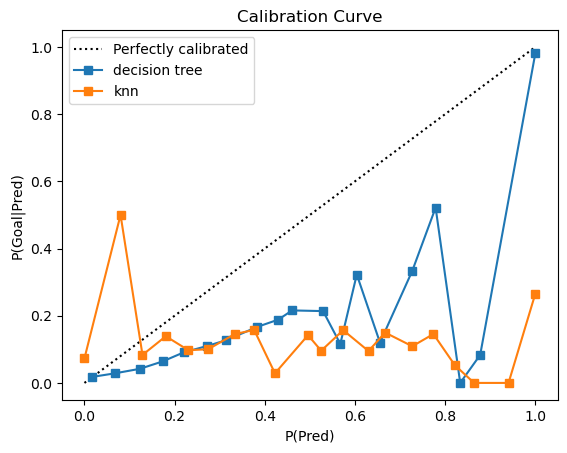

In [69]:
fig = plt.figure()
plt.title(f"Calibration Curve")
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for i in range(len(models)):
    prob_true, prob_pred = calibration_curve(y_val, probs[i], n_bins=20)
    plt.plot(prob_pred, prob_true, "s-", label="%s" % (models[i]))

plt.xlabel("P(Pred)")
plt.ylabel("P(Goal|Pred)")
plt.legend()

plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.show()

path_output_image = os.path.join("images", "best_shot_model", "calibration.jpg")
fig.savefig(path_output_image)
# experiment.log_figure(figure=fig)

# 6. Push trained model to comet

### a. Decision tree

In [91]:
from comet_ml import Experiment

In [92]:
y_val_pred = tree.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_tree)
roc_auc = auc(fpr, tpr)

print(f"accuracy: {accuracy}")
print(f"roc: {roc_auc}")

accuracy: 0.9086069660149054
roc: 0.7392906717791614


In [93]:
workspace_name = r"ift6758-b09-project"
project_name = r"ift6758-project-milestone2"

experiment = Experiment(api_key=os.environ.get('COMET_API_KEY'), project_name=project_name, workspace=workspace_name)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/ee5045d8c9bf416b85e3e0196d37239a



In [95]:
experiment.log_model("decision_tree", path_output_tree_model)
experiment.log_metrics({"accuracy": accuracy, "roc": roc_auc})

### b. KNN

In [96]:
y_val_pred = knn_best.predict(X_val)
accuracy = accuracy_score(y_val, y_val_pred)
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba_knn)
roc_auc = auc(fpr, tpr)

print(f"accuracy: {accuracy}")
print(f"roc: {roc_auc}")

accuracy: 0.8597502239196931
roc: 0.5905067275527858


In [97]:
experiment.log_model("knn", path_output_knn_model)
experiment.log_metrics({"accuracy": accuracy, "roc": roc_auc})

In [98]:
experiment.end()


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-b09-project/ift6758-project-milestone2/ee5045d8c9bf416b85e3e0196d37239a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [2] : (0.8597502239196931, 0.9086069660149054)
COMET INFO:     roc [2]      : (0.5905067275527858, 0.7392906717791614)
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (430